Requirements

In [ ]:
!pip install albumentations==0.4.6
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install pycocotools
!pip install cpython
!pip install wget

     |████████████████████████████████| 117 kB 8.4 MB/s 
     |████████████████████████████████| 948 kB 55.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ca1972a9adeccb4bd8ee64aa3de1f94c306a97919bdb3bff8a6ef388ff6f737f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Created wheel for cpython: filename=cPython-0.0.6-py3-none-any.whl size=4913 sha256=c7b225897b12b4d37ad387d90c6935982bb721a5115e1c60d6fb134e5928f386
  Stored in directory: /root/.cache/pip/wheels/88/92/ea/c32ad929e979a7303e010b29c736c793

More requirement + Dataset

In [ ]:
!git clone https://github.com/pytorch/vision

import sys
sys.path.insert(0, "/content/vision/references/detection")

dataset_path = "/content/drinkscoco"

Cloning into 'vision'...
remote: Enumerating objects: 129988, done.
remote: Total 129988 (delta 0), reused 0 (delta 0), pack-reused 129988
Receiving objects: 100% (129988/129988), 254.74 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (113956/113956), done.


In [ ]:
import wget
import shutil

url = "https://github.com/st0bb3n/ObjectDetection-Drinks/releases/download/Dataset/drinkscoco.zip"
x = wget.download(url, "data.zip")

shutil.unpack_archive("data.zip","drinkscoco")

Main function + Dataset Class

In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
import matplotlib.pyplot as plt
import datetime
import time
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
#from albumentations.pytorch import ToTensorV2
from engine import evaluate, train_one_epoch
import utils

class Drinks(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        return image/255

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        #targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['image_id'] = torch.tensor([index])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return torchvision.transforms.ToTensor()(image), targ # scale images

    def __len__(self):
        return len(self.ids)

test.py

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

train_dataset = Drinks(root=dataset_path, transforms=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

device = torch.device("cuda")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

dataset = Drinks(root=dataset_path, transforms=torchvision.transforms.ToTensor())
test_dataset = Drinks(root=dataset_path, split="test", transforms=torchvision.transforms.ToTensor())

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

evaluate(model, data_loader_test, device=device)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
creating index...
index created!
Test:  [ 0/59]  eta: 0:00:09  model_time: 0.0345 (0.0345)  evaluator_time: 0.0075 (0.0075)  time: 0.1613  data: 0.1180  max mem: 778
Test:  [58/59]  eta: 0:00:00  model_time: 0.0221 (0.0234)  evaluator_time: 0.0059 (0.0064)  time: 0.0328  data: 0.0034  max mem: 778
Test: Total time: 0:00:02 (0.0372 s / it)
Averaged stats: model_time: 0.0221 (0.0234)  evaluator_time: 0.0059 (0.0064)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (A

train.py

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

train_dataset = Drinks(root=dataset_path, transforms=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
#output = model(images, targets)
output = model(images, targets)
device = torch.device("cuda") # use GPU to train
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

dataset = Drinks(root=dataset_path, transforms=torchvision.transforms.ToTensor())
test_dataset = Drinks(root=dataset_path, split="test", transforms=torchvision.transforms.ToTensor())

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    #lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    
model.eval()
torch.save(model, "trainedmodel.pth")
torch.cuda.empty_cache()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [  0/236]  eta: 0:01:25  lr: 0.000053  loss: 2.0227 (2.0227)  loss_classifier: 1.6917 (1.6917)  loss_box_reg: 0.2350 (0.2350)  loss_objectness: 0.0869 (0.0869)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 0.3619  data: 0.1676  max mem: 778
Epoch: [0]  [ 50/236]  eta: 0:00:20  lr: 0.002178  loss: 0.9172 (1.0563)  loss_classifier: 0.4004 (0.6216)  loss_box_reg: 0.4947 (0.3838)  loss_objectness: 0.0277 (0.0447)  loss_rpn_box_reg: 0.0049 (0.0061)  time: 0.0954  data: 0.0130  max mem: 793
Epoch: [0]  [100/236]  eta: 0:00:13  lr: 0.004304  loss: 0.9379 (1.0928)  loss_classifier: 0.3266 (0.5387)  loss_box_reg: 0.5644 (0.5184)  loss_objectness: 0.0100 (0.0301

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


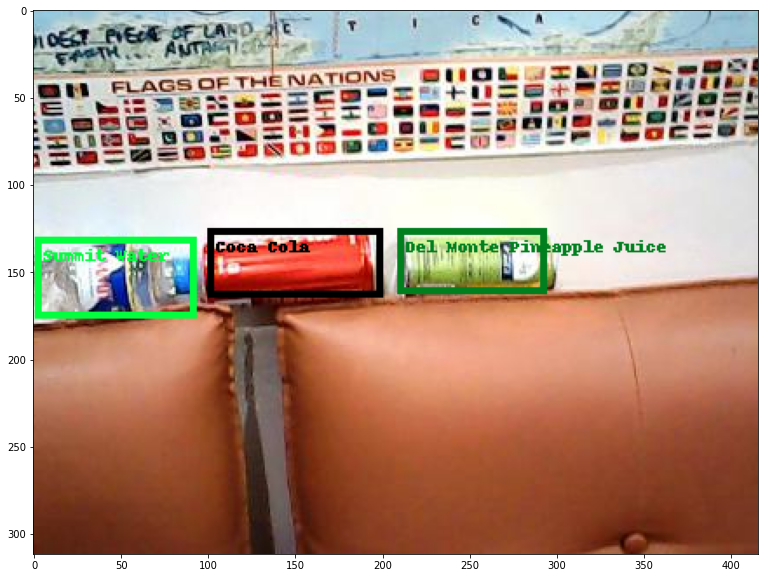

In [ ]:
img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))